In [1]:
import pypsa
import yaml
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import seaborn as sns

import sys
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Patch
from matplotlib.legend_handler import HandlerPatch


import cartopy.crs as ccrs
import cartopy
from cartopy.io import shapereader

import multiprocessing as mp
from itertools import product

from pypsa.plot import projected_area_factor
from pypsa.descriptors import get_switchable_as_dense as as_dense

PATH = "https://github.com/fneum/spatial-sector/tree/dbfda1f7f12be0176335d665f9b4814a57105b3e/workflows"
SCRIPTS_PATH = "https://github.com/PyPSA/pypsa-eur/tree/008539d635c1da9fff3d4852bd0ac0444e9cd52c/scripts/"

sys.path.append(SCRIPTS_PATH)
%cd /Users/e7_qpham/pypsa-eur/scripts

plt.style.use(["bmh"])

xr.set_options(display_style="html")

%matplotlib inline

/Users/e7_qpham/pypsa-eur/scripts


In [2]:
n2=pypsa.Network(r"./elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc")

INFO:pypsa.io:Imported network elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
def rename_techs(label):
    if "H2" in label:
        label = "hydrogen storage"
    elif label == "solar":
        label = "solar PV"
    elif label == "offwind-ac":
        label = "offshore wind ac"
    elif label == "offwind-dc":
        label = "offshore wind dc"
    elif label == "onwind":
        label = "onshore wind"
    elif label == "ror":
        label = "hydroelectricity"
    elif label == "hydro":
        label = "hydroelectricity"
    elif label == "PHS":
        label = "hydroelectricity"
    elif "battery" in label:
        label = "battery storage"

    return label

In [4]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1: continue
            names = ifind.index[ifind == i]
            c.df.loc[names, 'location'] = names.str[:i]

In [5]:
with open(r"./config.yaml") as file:
    config = yaml.safe_load(file)

In [6]:
tech_colors = config["plotting"]["tech_colors"]
tech_colors["load"] = "red"

In [7]:
class HandlerCircle(HandlerPatch):
    """
    Legend Handler used to create circles for legend entries.

    This handler resizes the circles in order to match the same dimensional
    scaling as in the applied axis.
    """

    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        fig = legend.get_figure()
        ax = legend.axes

        unit = np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0][1]
        radius = orig_handle.get_radius() * unit * (72 / fig.dpi)
        center = 5 - xdescent, 3 - ydescent
        p = plt.Circle(center, radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


def add_legend_circles(
    ax, sizes, labels, scale=1, srid=None, patch_kw={}, legend_kw={}
):
    if srid is not None:
        area_correction = projected_area_factor(ax, n.srid) ** 2
        sizes = [s * area_correction for s in sizes]

    handles = make_legend_circles_for(sizes, scale, **patch_kw)

    legend = ax.legend(
        handles, labels, handler_map={Circle: HandlerCircle()}, **legend_kw
    )

    ax.add_artist(legend)


def add_legend_lines(ax, sizes, labels, scale=1, patch_kw={}, legend_kw={}):
    handles = [Line2D([0], [0], linewidth=s / scale, **patch_kw) for s in sizes]

    legend = ax.legend(handles, labels, **legend_kw)

    ax.add_artist(legend)


def add_legend_patch(ax, colors, labels, patch_kw={}, legend_kw={}):
    handles = [Patch(facecolor=c, **patch_kw) for c in colors]

    legend = ax.legend(handles, labels, **legend_kw)

    ax.add_artist(legend)


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]

In [10]:
def curtailment(n, carriers=None):
    avail = n.generators_t.p_max_pu * n.generators.p_nom_opt
    dispatch = n.generators_t.p

    curtail = n.snapshot_weightings.generators @ (avail - dispatch)

    curtail = (
        curtail.groupby([n.generators.bus.map(n.buses.location), n.generators.carrier])
        .sum()
        .unstack()
    )

    if carriers is not None:
        curtail = curtail[carriers]

    return curtail.drop("EU", axis=0).stack().div(1e6)

In [11]:
curtailment(n2)#.sum()

bus    carrier                                  
AL1 0  offwind-ac                                   4.564590e-08
       onwind                                       1.291134e-08
       residential rural solar thermal              2.326471e-07
       residential urban decentral solar thermal    2.830180e-07
       ror                                          4.863283e-04
                                                        ...     
SK1 0  services rural solar thermal                 8.409364e-08
       services urban decentral solar thermal       9.076000e-08
       solar                                        5.426467e-01
       solar rooftop                                1.364549e-04
       urban central solar thermal                  1.674179e-07
Length: 2373, dtype: float64

In [13]:
available = n2.snapshot_weightings.generators @ (
    n2.generators_t.p_max_pu * n2.generators.p_nom_opt
)
available

Generator
AL1 0 offwind-ac                                             1.770553e-01
AL1 0 onwind                                                 2.872085e-02
AL1 0 residential rural solar thermal collector              5.729026e-01
AL1 0 residential urban decentral solar thermal collector    7.516842e-01
AL1 0 ror                                                    1.772497e+05
                                                                 ...     
SK1 0 services rural solar thermal collector                 1.769770e-01
SK1 0 services urban decentral solar thermal collector       2.027931e-01
SK1 0 solar                                                  2.381063e+07
SK1 0 solar rooftop                                          5.811971e+06
SK1 0 urban central solar thermal collector                  4.689137e-01
Name: generators, Length: 2375, dtype: float64

In [14]:
available = (
    available.groupby(n2.generators.carrier)
    .sum()
    .drop(set(n2.generators.carrier.values).intersection(["gas", "oil"]))
    .div(1e6)
)  # TWh
available

carrier
offwind-ac                                     53.662434
offwind-dc                                    258.103525
onwind                                       2536.737677
residential rural solar thermal                 0.000061
residential urban decentral solar thermal       0.000081
ror                                           169.155430
services rural solar thermal                    0.000058
services urban decentral solar thermal          0.000071
solar                                        1390.242387
solar rooftop                                 552.485794
urban central solar thermal                     7.253727
Name: generators, dtype: float64

In [15]:
used = n2.snapshot_weightings.generators @ n2.generators_t.p
used

Generator
AL1 0 offwind-ac       1.314094e-01
AL1 0 onwind           1.580951e-02
AL1 0 ror              1.767634e+05
AL1 0 solar            1.276450e+07
AT1 0 onwind           2.011348e+07
                           ...     
SE2 5 solar rooftop    1.941783e+06
SE2 6 solar rooftop    2.453489e+00
SE2 7 solar rooftop    1.239788e+05
SI1 0 solar rooftop    2.460860e+06
SK1 0 solar rooftop    5.811834e+06
Name: generators, Length: 2375, dtype: float64

In [16]:
used = (
    used.groupby(n2.generators.carrier)
    .sum()
    .drop(set(n2.generators.carrier.values).intersection(["gas", "oil"]))
    .div(1e6)
)  # TWh
used

carrier
offwind-ac                                     46.070569
offwind-dc                                    243.541409
onwind                                       2321.336402
residential rural solar thermal                 0.000036
residential urban decentral solar thermal       0.000052
ror                                           168.773888
services rural solar thermal                    0.000035
services urban decentral solar thermal          0.000044
solar                                        1313.372140
solar rooftop                                 551.875010
urban central solar thermal                     7.251115
Name: generators, dtype: float64

In [17]:
curtailed = available - used
curtailed.sum()

315.4205440181156

In [41]:
curtailment(n2).filter(like="ror").filter(like="DE").sum()

0.059467427292735

In [53]:
n2.links_t.p0.filter(like="methanolisation").filter(like="DE").sum().sum()

143.3934412184437

In [54]:
n2.generators.eval("capital_cost * p_nom_opt").filter(like="DE").div(1e9).groupby(
    n2.generators.carrier
).sum()

carrier
offwind-ac                                    0.379552
offwind-dc                                    4.380764
onwind                                       14.028884
residential rural solar thermal               0.000001
residential urban decentral solar thermal     0.000001
ror                                           0.848572
services rural solar thermal                  0.000001
services urban decentral solar thermal        0.000001
solar                                         4.933939
solar rooftop                                 3.301162
urban central solar thermal                   0.000002
dtype: float64

In [37]:
def plot_pipeline_loading(network, min_capacity=20, fn=None):
    line_width_factor = 2e3

    n = network.copy()

    n.mremove("Bus", n.buses.index[n.buses.carrier != "AC"])
    n.mremove("Link", n.links.index[~n.links.carrier.str.contains("H2 pipeline")])

    n.mremove("Link", n.links.index[n.links.p_nom_opt < min_capacity])
    n.links.bus0 = n.links.bus0.str.replace(" H2", "")
    n.links.bus1 = n.links.bus1.str.replace(" H2", "")

    link_loading = n.links_t.p0.abs().mean() / n.links.p_nom_opt * 100

    crs = ccrs.EqualEarth()

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs},dpi=300)

    cmap = plt.cm.OrRd
    norm = mcolors.Normalize(vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    link_colors = pd.Series(
        list(map(mcolors.to_hex, cmap(norm(link_loading)))), index=link_loading.index
    )

    n.plot(
        geomap=True,
        ax=ax,
        bus_sizes=0.005,
        bus_colors="k",
        link_colors=link_colors,
        link_widths=n.links.p_nom_opt / line_width_factor,
        branch_components=["Link"],
    )

    sizes = [1, 3]
    labels = [f"{s} GW" for s in sizes]
    add_legend_lines(
        ax,
        sizes,
        labels,
        scale=line_width_factor / 1e3,
        legend_kw=dict(title="Pipe Capacity", bbox_to_anchor=(1.03, 0.62)),
        patch_kw=dict(color="lightgrey"),
    )

    axins = ax.inset_axes([0.05, 0.8, 0.3, 0.2])
    curve = link_loading.sort_values().reset_index(drop=True)
    curve.index = [c / curve.size * 100 for c in curve.index]
    curve.plot(
        ax=axins,
        ylim=(-5, 105),
        yticks=[0, 25, 50, 75, 100],
        c="firebrick",
        linewidth=1.5,
    )
    axins.annotate("loading [%]", (3, 83), color="darkgrey", fontsize=9)
    axins.annotate("pipes [%]", (55, 7), color="darkgrey", fontsize=9)
    axins.grid(True)

    cbar = plt.colorbar(
        sm,
        orientation="vertical",
        shrink=0.7,
        ax=ax,
        label="Average Loading / Pipe Capacity [%]",
    )

    #if fn is not None:
    #    plt.savefig(fn, bbox_inches="tight")
    #    plt.close()

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


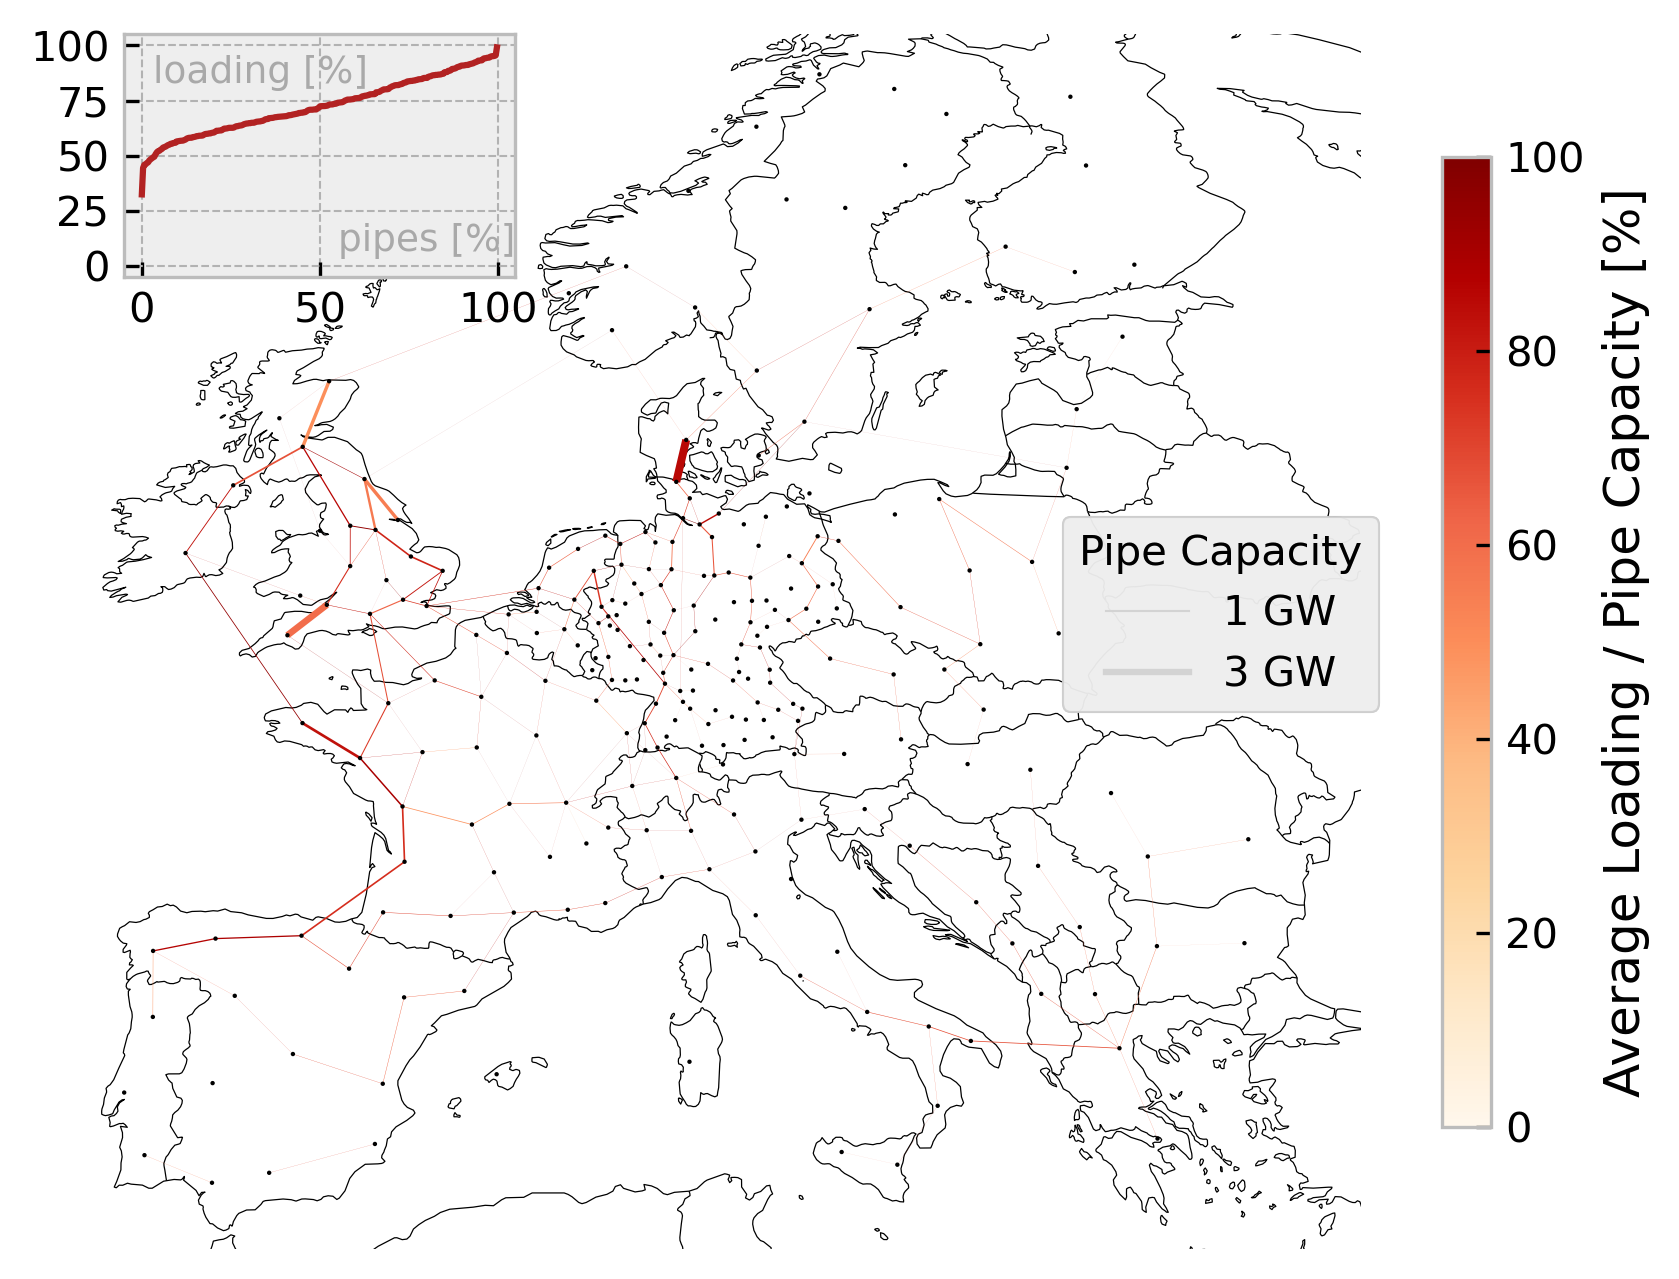

In [38]:
plot_pipeline_loading(n2)

In [34]:

n_s = n2.copy()

n_s.mremove("Bus", n_s.buses.index[n_s.buses.carrier != "AC"])
n_s.mremove("Link", n_s.links.index[~n_s.links.carrier.str.contains("H2 pipeline")])

n_s.mremove("Link", n_s.links.index[n_s.links.p_nom_opt < 0])
n_s.links.bus0 = n_s.links.bus0.str.replace(" H2", "")
n_s.links.bus1 = n_s.links.bus1.str.replace(" H2", "")
#link_loading1 = n_s.links_t.p0.abs().mean() / n_s.links.p_nom_opt * 100
#link_loading1 = n_s.links_t.p0.abs().mean() #/ n_s.links.p_nom_opt * 100
link_loading1 = n_s.links.p_nom_opt
link_loading1.sort_values(ascending=False).head(15)

Link
H2 pipeline DE1 72 -> DK1 0     3793.511023
H2 pipeline GB0 11 -> GB0 16    3148.595787
H2 pipeline GB0 13 -> GB0 3     1626.640415
H2 pipeline GB0 17 -> GB0 8     1612.788613
H2 pipeline FR1 21 -> FR1 3     1287.999368
H2 pipeline GB0 4 -> GB0 8      1140.615730
H2 pipeline GB0 3 -> GB5 0       834.560781
H2 pipeline FR1 0 -> FR1 23      805.757876
H2 pipeline GB0 14 -> GB0 15     799.416019
H2 pipeline ES1 6 -> FR1 0       797.872881
H2 pipeline GB0 15 -> GB0 4      776.632514
H2 pipeline FR1 21 -> FR1 23     726.416905
H2 pipeline DE1 44 -> NL1 4      700.463782
H2 pipeline DE1 33 -> DE1 67     687.191329
H2 pipeline ES1 5 -> ES1 8       630.956124
Name: p_nom_opt, dtype: float64

In [36]:
link_loading1.describe()

count     474.000000
mean      118.742611
std       290.342270
min         0.002946
25%         7.880237
50%        34.146659
75%       113.877891
max      3793.511023
Name: p_nom_opt, dtype: float64

In [32]:
def calculate_twkm(n, selection=None, decimals=1, which="optimal"):
    if selection is None:
        selection = [
            "H2 pipeline",
            "H2 pipeline retrofitted",
            "gas pipeline",
            "gas pipeline new",
            "DC",
        ]

    twkm = n.links.loc[n.links.carrier.isin(selection)]

    if which == "optimal":
        link_request = "p_nom_opt"
        line_request = "s_nom_opt"
    elif which == "added":
        link_request = "(p_nom_opt - p_nom)"
        line_request = "(s_nom_opt - s_nom)"
    elif which == "existing":
        link_request = "p_nom"
        line_request = "s_nom"

    twkm = twkm.eval(f"length*{link_request}").groupby(twkm.carrier).sum() / 1e6  # TWkm
    twkm["AC"] = n.lines.eval(f"length*{line_request}").sum() / 1e6  # TWkm

    twkm.index.name = None

    return twkm.round(decimals)

In [33]:
calculate_twkm(n2, which="optimal")

DC              48.9
H2 pipeline     10.0
AC             355.4
dtype: float64

In [25]:
pd.DataFrame(
    {key: calculate_twkm(n2, which=key) for key in ["optimal", "added", "existing"]}
).stack()

DC           optimal      48.9
             added        40.4
             existing      8.6
H2 pipeline  optimal      10.0
             added        10.0
             existing      0.0
AC           optimal     355.4
             added        40.5
             existing    314.9
dtype: float64

In [37]:
# Function to shift the year of a datetime index
def shift_year_to_2030(datetime_index):
    return datetime_index.map(lambda dt: dt.replace(year=2030 if dt.year == 2013 else dt.year))

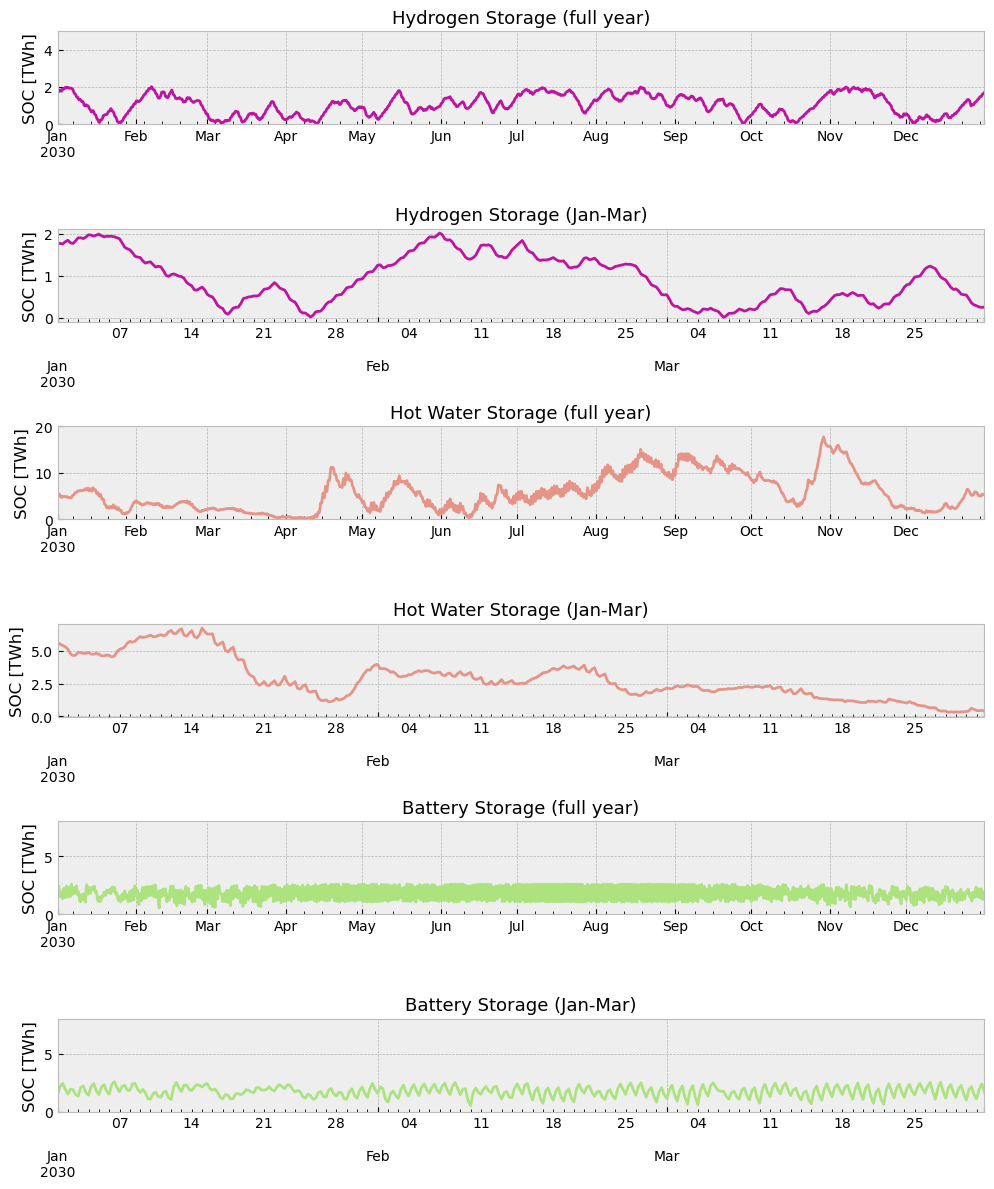

In [40]:
# Apply the year shift to all relevant dataframes
n2.stores_t.e.index = shift_year_to_2030(n2.stores_t.e.index)

fig, axs = plt.subplots(6, 1, figsize=(10, 12))

ax = axs[0]
n2.stores_t.e.filter(like="H2 Store", axis=1).sum(axis=1).div(1e6).plot(
    ax=ax,
    ylabel="SOC [TWh]",
    xlabel="",
    color=tech_colors["hydrogen storage"],
    ylim=(0, 5),
)
ax.set_title("Hydrogen Storage (full year)", fontsize=13)

ax = axs[2]
n2.stores_t.e.filter(like="water tank", axis=1).sum(axis=1).div(1e6).plot(
    ax=ax,
    ylabel="SOC [TWh]",
    xlabel="",
    color=tech_colors["hot water storage"],
    ylim=(0, 20),
)
ax.set_title("Hot Water Storage (full year)", fontsize=13)

ax = axs[1]
n2.stores_t.e.filter(like="H2 Store", axis=1).sum(axis=1).loc["2030-01":"2030-03"].div(
    1e6
).plot(ax=ax, ylabel="SOC [TWh]", xlabel="", color=tech_colors["hydrogen storage"])
ax.set_title("Hydrogen Storage (Jan-Mar)", fontsize=13)

ax = axs[3]
n2.stores_t.e.filter(like="water tank", axis=1).sum(axis=1).loc["2030-01":"2030-03"].div(
    1e6
).plot(ax=ax, ylabel="SOC [TWh]", xlabel="", color=tech_colors["hot water storage"])
ax.set_title("Hot Water Storage (Jan-Mar)", fontsize=13)

ax = axs[5]
n2.stores_t.e.filter(like="battery", axis=1).sum(axis=1).loc["2030-01":"2030-03"].div(
    1e6
).plot(ax=ax, ylabel="SOC [TWh]", xlabel="", color=tech_colors["battery"], ylim=(0, 8))
ax.set_title("Battery Storage (Jan-Mar)", fontsize=13)

ax = axs[4]
n2.stores_t.e.filter(like="battery", axis=1).sum(axis=1).div(
    1e6
).plot(ax=ax, ylabel="SOC [TWh]", xlabel="", color=tech_colors["battery"], ylim=(0, 8))
ax.set_title("Battery Storage (full year)", fontsize=13)

plt.tight_layout()

#plt.savefig(f"{OUTPUT_SCENARIO}/soc.pdf", bbox_inches="tight")